# DQN


### Training of DQN in Tensorflow
--------------------------

In [33]:
#
from util import *
from dlg_manager import *
from alg import *
from agent import *
from user_sim import *
from state_tracker import *
import random
from config import *
import matplotlib.pyplot as plt
import numpy as np
from nlg import *
from six.moves import cPickle as pickle
import IPython
import copy, argparse, json

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data
-------------------

#### Action Set

In [2]:
#
act_set_path = './data/dia_acts.txt'
act_set = text_to_dict(act_set_path)
sample_dict(act_set)

keys = 11
Sample of dict:
- greeting: 4
- confirm_question: 2
- closing: 5
- inform: 1
- thanks: 7


### slot set

In [3]:
#
slots_set_path = "./data/slot_set.txt"
slot_set = text_to_dict(slots_set_path)
sample_dict(slot_set)

keys = 29
Sample of dict:
- starttime: 20
- greeting: 9
- price: 18
- video_format: 24
- critic_rating: 4


### movie dic: info about movie

In [4]:
#
movie_kb_path = "./data/movie_kb.1k.p"
movie_kb = pickle.load(open(movie_kb_path, 'rb'), encoding="latin")
sample_dict(movie_kb, sample_size=1)

keys = 991
Sample of dict:
- 110: {'date': 'tonight', 'city': 'los angeles', 'moviename': 'The Witch', 'theater': 'Regal LA LIVE Stadium 14', 'starttime': '8:30pm'}


# Language Generator (pretrained)
-------------------

In [5]:
#
nlg_model_path = './data/trained_model/nlg/lstm_tanh_relu_[1468202263.38]_2_0.610.p'
nlg_model = Nlg()
nlg_model.load_nlg_model(nlg_model_path)
diaact_nl_pairs_path = "./data/nlg/dia_act_nl_pairs.v6.json"
nlg_model.load_predefine_act_nl_pairs(diaact_nl_pairs_path)

## Model Params

In [6]:
#
model_params = pickle.load(open(nlg_model_path, 'rb'), encoding='latin1')
params = model_params['params']
params['batch_size'] = 16
batch_size = 16
save_check_point = 20
params['trained_model_path'] = None
for k in params:
    print("{}: {}".format(k, params[k]))

grad_clip: -0.0001
dia_slot_val: 2
reg_cost: 0.001
data_path: .\data\movieMultiLine.Annot.Corrected.Final.v3.csv
save_check_point: 20
slot_rep: 1
max_epochs: 200
sdgtype: rmsprop
init_rnn: 0
cv_fold: 6
write_model_dir: .\checkpoints\template\07102016\
valid_test: 0
pretrained_model_path: None
check_point: 20
decay_rate: 0.999
feed_recurrence: 0
hidden_size: 100
activation_func: relu
momentum: 0.1
learning_rate: 0.001
batch_size: 16
act_set: data/dia_acts.txt
smooth_eps: 1e-08
split_method: 1
slot_set: data/slot_set.txt
eva_metric: 2
model: lstm_tanh
trained_model_path: None


# User Simulator
-------------------

### goal

In [7]:
#
goal_file_path = './data/user_goals_first_turn_template.part.movie.v1.p'
all_goal_set = pickle.load(open(goal_file_path, 'rb'), encoding="latin")
print("goals length: {}".format(len(all_goal_set)))
print("Sample the first goal: \n{}".format(all_goal_set[0]))

goals length: 128
Sample the first goal: 
{'request_slots': {}, 'diaact': 'request', 'inform_slots': {'city': 'birmingham', 'numberofpeople': '1', 'theater': 'carmike summit 16', 'state': 'al', 'starttime': 'around 2pm', 'date': 'today', 'moviename': 'zootopia'}}


### Split goal set

In [8]:
# split goal set
split_fold = params.get('split_fold', 5)
goal_set = {'train':[], 'valid':[], 'test':[], 'all':[]}
for u_goal_id, u_goal in enumerate(all_goal_set):
    if u_goal_id % split_fold == 1: goal_set['test'].append(u_goal)
    else: goal_set['train'].append(u_goal)
    goal_set['all'].append(u_goal)
print(len(goal_set['train']))
print(len(goal_set['valid']))
print(len(goal_set['test']))
print(len(goal_set['all']))

102
0
26
128


### user simulator param

In [9]:
#
usersim_params = {}
usersim_params['max_turn'] = 40
usersim_params['slot_err_prob'] = 0.00
# slot_err_mode: 0 for slot_val only; 1 for three errs
usersim_params['slot_err_mode'] = 0
usersim_params['intent_err_prob'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
usersim_params['run_mode'] = 0
# 0 for dia_act level; 1 for NL level
usersim_params['act_level'] = 0
# train/test/all; default is all
usersim_params['learn_phase'] = 'all'

### a movie dictionary for user simulator - slot:possible values

In [10]:
#
movie_dict_path = './data/user/dicts.v3.p'
movie_dictionary = pickle.load(open(movie_dict_path, 'rb'), encoding="latin")
samples = sample_dict(movie_dictionary, sample_size=1)

keys = 20
Sample of dict:
- price: ['$20', '$10', 'cheapest', 'adult price is 8', '32']


###  Create a User

In [11]:
user = RuleSimulator(movie_dictionary, act_set, slot_set, goal_set, usersim_params)
user.set_nlg_model(nlg_model)

# Agent
-------------------

## param

In [12]:
#
agent_params = {}
# maximum length of each dialog (default=20, 0=no maximum length)
agent_params['max_turn'] = 40
# Epsilon to determine stochasticity of epsilon-greedy agent policies
agent_params['epsilon'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
agent_params['agent_run_mode'] = 3
# 0 for dia_act level; 1 for NL level
agent_params['agent_act_level'] = 0

############### DQN #################
# the size for experience replay
agent_params['experience_replay_pool_size'] = 10000
# # the hidden size for DQN
agent_params['dqn_hidden_size'] = 60
agent_params['batch_size'] = 16
# # gamma for DQN
agent_params['gamma'] = 0.9
# # predict model for DQN
agent_params['predict_mode'] = True
agent_params['trained_model_path'] = params['pretrained_model_path']
#####################################
print("pretrained model path = {}".format(agent_params['trained_model_path']))
# 0: no warm start; 1: warm start for training
agent_params['warm_start'] = 1
# run_mode: 0 for NL; 1 for dia_act
agent_params['cmd_input_mode'] = 0

success_rate_threshold = 0.3

pretrained model path = None


### create an agent

In [13]:
# agent = RequestBasicsAgent(movie_kb, act_set, slot_set, agent_params)
# agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
# agt = 9
agt = 10
agent_params['batch_size']  = batch_size
if agt == 9:
    agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
else:
    agent = DQNAgentTF(movie_kb, act_set, slot_set, agent_params)

agent.set_nlg_model(nlg_model)

80


# Dialog Manager
-------------------

In [14]:
dlg_manager = DlgManager(agent, user, act_set, slot_set, movie_kb)

## Running Episodes
-------------------

### Param

In [15]:
#
status = {'successes': 0, 'count': 0, 'cumulative_reward': 0}
# the size of validation set
simulation_epoch_size = 100
# the number of epochs for warm start 
warm_start_epochs = 120
# num_episodes = 60

In [16]:
""" Warm_Start Simulation (by Rule Policy) """
def warm_start_simulation():
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(warm_start_epochs):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("warm_start simulation episode %s: Success" % (episode))
#                 else: print ("warm_start simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        if len(agent.experience_replay_pool) >= agent.experience_replay_pool_size:
            break
    
    agent.warm_start = 2
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print ("Warm_Start %s epochs, success rate %s, ave reward %s, ave turns %s" % (episode+1, res['success_rate'], res['ave_reward'], res['ave_turns']))
    print ("Current experience replay buffer size %s" % (len(agent.experience_replay_pool)))

In [17]:
def simulation_epoch(simulation_epoch_size):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(simulation_epoch_size):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("simulation episode %s: Success" % (episode))
#                 else: print ("simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
    
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print("simulation success rate %s, ave reward %s, ave turns %s" % (res['success_rate'], res['ave_reward'], res['ave_turns']))
    return res

In [18]:
def run_episodes(count, status):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    
    if agt >= 9 and params['trained_model_path'] == None and agent.warm_start == 1:
        print ('warm_start starting ...')
        warm_start_simulation()
        print ('warm_start finished, start RL training ...')
    
    for episode in range(count):
        print ("----------------- Episode: %s ----------------- " % (episode))
        dlg_manager.init_episode()
        episode_over = False
        
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
                
            if episode_over:
                if reward > 0:
                    print ("Successful Dialog!")
                    successes += 1
#                 else: print ("Failed Dialog!")
                
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        # simulation
        if agt >= 9 and params['trained_model_path'] == None:
            agent.predict_mode = True
            simulation_res = simulation_epoch(simulation_epoch_size)
            
            performance_records['success_rate'][episode] = simulation_res['success_rate']
            performance_records['ave_turns'][episode] = simulation_res['ave_turns']
            performance_records['ave_reward'][episode] = simulation_res['ave_reward']
            
            if simulation_res['success_rate'] >= best_res['success_rate']:
                if simulation_res['success_rate'] >= success_rate_threshold: # threshold = 0.30
                    agent.experience_replay_pool = [] 
                    simulation_epoch(simulation_epoch_size)
                
#             if simulation_res['success_rate'] > best_res['success_rate']:
#                 best_model['model'] = copy.deepcopy(agent)
#                 best_res['success_rate'] = simulation_res['success_rate']
#                 best_res['ave_reward'] = simulation_res['ave_reward']
#                 best_res['ave_turns'] = simulation_res['ave_turns']
#                 best_res['epoch'] = episode
                
            loss = agent.train(batch_size, 1)
            if agt == 10: 
                agent.model.update_target_params()
            else: 
                agent.clone_dqn = copy.deepcopy(agent.dqn)
                
            agent.predict_mode = False
            
            print ("Simulation success rate %s, Ave reward %s, Ave turns %s, Best success rate %s" % (performance_records['success_rate'][episode], performance_records['ave_reward'][episode], performance_records['ave_turns'][episode], best_res['success_rate']))
#             if episode % save_check_point == 0 and params['trained_model_path'] == None: # save the model every 10 episodes
#                 save_model(params['write_model_dir'], agt, best_res['success_rate'], best_model['model'], best_res['epoch'], episode)
#                 save_performance_records(params['write_model_dir'], agt, performance_records)
        curve.append(successes/(episode+1))
        losses.append(loss)
        print("Progress: %s / %s, Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (episode+1, count, successes, episode+1, float(cumulative_reward)/(episode+1), float(cumulative_turns)/(episode+1)))
    print("Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (successes, count, float(cumulative_reward)/count, float(cumulative_turns)/count))
    status['successes'] += successes
    status['count'] += count
    
#     if agt == 9 and params['traained_model_path'] == None:
#         save_model(params['write_model_dir'], agt, float(successes)/count, best_model['model'], best_res['epoch'], count)
#         save_performance_records(params['write_model_dir'], agt, performance_records)


## Run a Warm Start

# Train & Eval
-------------------

In [19]:
performance_records = {}
performance_records['success_rate'] = {}
performance_records['ave_turns'] = {}
performance_records['ave_reward'] = {}

best_model = {}
best_res = {'success_rate': 0, 'ave_reward':float('-inf'), 'ave_turns': float('inf'), 'epoch':0}

curve = []
losses = []
agent.warm_start = 1
run_episodes(100, status)

warm_start starting ...
Warm_Start 120 epochs, success rate 0.39, ave reward -9.6, ave turns 19.2
Current experience replay buffer size 960
warm_start finished, start RL training ...
----------------- Episode: 0 ----------------- 
simulation success rate 0.0, ave reward -58.9, ave turns 39.8
Train on : 2971
- cur bellman err 10.2900, experience replay pool 2971
Simulation success rate 0.0, Ave reward -58.9, Ave turns 39.8, Best success rate 0
Progress: 1 / 100, Success rate: 0 / 1 Avg reward: -60.00 Avg turns: 42.00
----------------- Episode: 1 ----------------- 
simulation success rate 0.0, ave reward -56.22, ave turns 34.44
Train on : 4693
- cur bellman err 5.5386, experience replay pool 4693
Simulation success rate 0.0, Ave reward -56.22, Ave turns 34.44, Best success rate 0
Progress: 2 / 100, Success rate: 0 / 2 Avg reward: -60.00 Avg turns: 42.00
----------------- Episode: 2 ----------------- 
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 6793
- cur bell

Successful Dialog!
simulation success rate 0.26, ave reward -25.1, ave turns 34.6
Train on : 3262
- cur bellman err 0.5792, experience replay pool 3262
Simulation success rate 0.26, Ave reward -25.1, Ave turns 34.6, Best success rate 0
Progress: 24 / 100, Success rate: 5 / 24 Avg reward: -32.21 Avg turns: 36.42
----------------- Episode: 24 ----------------- 
simulation success rate 0.44, ave reward -0.79, ave turns 29.18
simulation success rate 0.39, ave reward -7.27, ave turns 30.14
Train on : 1507
- cur bellman err 1.5979, experience replay pool 1507
Simulation success rate 0.44, Ave reward -0.79, Ave turns 29.18, Best success rate 0
Progress: 25 / 100, Success rate: 5 / 25 Avg reward: -33.32 Avg turns: 36.64
----------------- Episode: 25 ----------------- 
simulation success rate 0.42, ave reward -3.54, ave turns 29.88
simulation success rate 0.3, ave reward -19.75, ave turns 33.5
Train on : 1675
- cur bellman err 0.8341, experience replay pool 1675
Simulation success rate 0.42, Av

simulation success rate 0.43, ave reward -2.02, ave turns 29.24
simulation success rate 0.54, ave reward 12.97, ave turns 25.66
Train on : 1283
- cur bellman err 1.6261, experience replay pool 1283
Simulation success rate 0.43, Ave reward -2.02, Ave turns 29.24, Best success rate 0
Progress: 44 / 100, Success rate: 16 / 44 Avg reward: -10.98 Avg turns: 31.23
----------------- Episode: 44 ----------------- 
simulation success rate 0.51, ave reward 8.99, ave turns 26.42
simulation success rate 0.51, ave reward 8.92, ave turns 26.56
Train on : 1328
- cur bellman err 2.4803, experience replay pool 1328
Simulation success rate 0.51, Ave reward 8.99, Ave turns 26.42, Best success rate 0
Progress: 45 / 100, Success rate: 16 / 45 Avg reward: -12.07 Avg turns: 31.47
----------------- Episode: 45 ----------------- 
simulation success rate 0.48, ave reward 4.82, ave turns 27.56
simulation success rate 0.46, ave reward 2.12, ave turns 28.16
Train on : 1408
- cur bellman err 2.8598, experience repl

simulation success rate 0.65, ave reward 29.0, ave turns 20.0
Train on : 1000
- cur bellman err 5.1024, experience replay pool 1000
Simulation success rate 0.71, Ave reward 37.01, Ave turns 18.38, Best success rate 0
Progress: 64 / 100, Success rate: 23 / 64 Avg reward: -11.23 Avg turns: 30.72
----------------- Episode: 64 ----------------- 
simulation success rate 0.55, ave reward 15.37, ave turns 23.26
simulation success rate 0.53, ave reward 12.44, ave turns 24.32
Train on : 1216
- cur bellman err 4.6904, experience replay pool 1216
Simulation success rate 0.55, Ave reward 15.37, Ave turns 23.26, Best success rate 0
Progress: 65 / 100, Success rate: 23 / 65 Avg reward: -11.98 Avg turns: 30.89
----------------- Episode: 65 ----------------- 
Successful Dialog!
simulation success rate 0.68, ave reward 32.2, ave turns 20.8
simulation success rate 0.62, ave reward 24.55, ave turns 21.7
Train on : 1085
- cur bellman err 3.0242, experience replay pool 1085
Simulation success rate 0.68, Av

Successful Dialog!
simulation success rate 0.64, ave reward 26.62, ave turns 22.36
simulation success rate 0.59, ave reward 19.83, ave turns 23.94
Train on : 1197
- cur bellman err 3.9904, experience replay pool 1197
Simulation success rate 0.64, Ave reward 26.62, Ave turns 22.36, Best success rate 0
Progress: 84 / 100, Success rate: 35 / 84 Avg reward: -3.63 Avg turns: 29.26
----------------- Episode: 84 ----------------- 
Successful Dialog!
simulation success rate 0.81, ave reward 49.17, ave turns 18.06
simulation success rate 0.78, ave reward 44.7, ave turns 19.8
Train on : 990
- cur bellman err 5.6771, experience replay pool 990
Simulation success rate 0.81, Ave reward 49.17, Ave turns 18.06, Best success rate 0
Progress: 85 / 100, Success rate: 36 / 85 Avg reward: -2.69 Avg turns: 29.04
----------------- Episode: 85 ----------------- 
Successful Dialog!
simulation success rate 0.85, ave reward 56.17, ave turns 13.66
simulation success rate 0.81, ave reward 51.19, ave turns 14.02
T

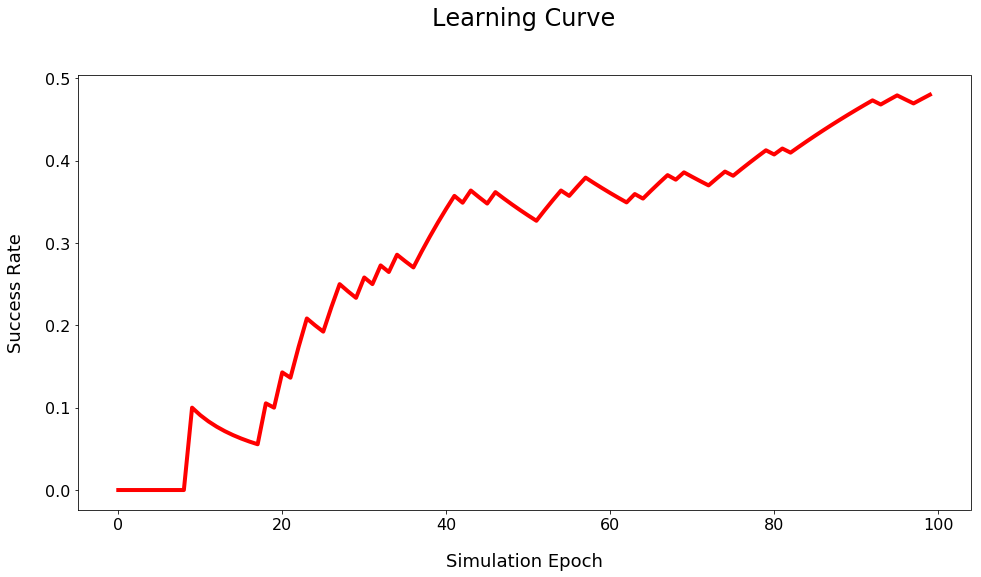

In [59]:
draw_learning_curve(curve)

In [31]:
import matplotlib.ft2font

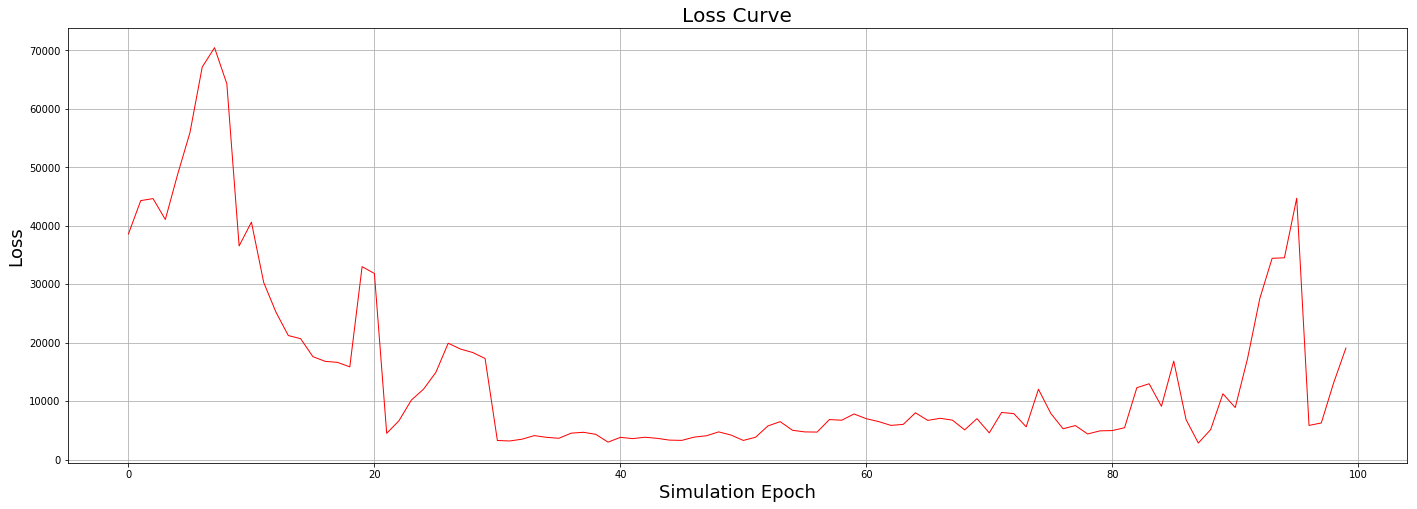

In [41]:
draw_loss_curve(losses)

In [ ]:
draw_loss_curve(losses[-100:])